# Imports 
Necessary imports, based in part on [this](https://www.kaggle.com/code/awsaf49/planttraits2024-kerascv-starter-notebook)

In [2]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow" # you can also use tensorflow or torch

# deep learning
import keras_cv
import keras
from keras import ops
import tensorflow as tf
import cv2
import umap.umap_ as umap

# data processing
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
import joblib
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pickle

# stats
from sklearn.metrics import mutual_info_score
from scipy.stats import wasserstein_distance

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils import plot_model
import pydot

# misc 
from config import config

# Data pre-processing

## Loading
The general format of each instance of the data is 
```
[ids*, ancillary data*, trait means*, traits sd*, image path]
```

In [3]:
from config import config
DATA_PATH = "../data"

# creating df that has image path and related ancillary data
df = pd.read_csv(DATA_PATH + "/train.csv")
df['image_path'] = f'{DATA_PATH}/train_images/' + df['id'].astype(str) + '.jpeg'
df.loc[:, config.aux_class_names] = df.loc[:, config.aux_class_names].fillna(-1)
display(df.head(2))
print(df.shape[0]) 

# same df but for the test data
test_df = pd.read_csv(DATA_PATH + "/test.csv")
test_df['image_path'] = f'{DATA_PATH}/test_images/'+ test_df['id'].astype(str) + '.jpeg'
FEATURE_COLS = list(test_df.columns[1:-1])
display(test_df.head(2))
print(test_df.shape[0])

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,../data/train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,../data/train_images/195542235.jpeg


55489


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,VOD_X_1997_2018_multiyear_mean_m04,VOD_X_1997_2018_multiyear_mean_m05,VOD_X_1997_2018_multiyear_mean_m06,VOD_X_1997_2018_multiyear_mean_m07,VOD_X_1997_2018_multiyear_mean_m08,VOD_X_1997_2018_multiyear_mean_m09,VOD_X_1997_2018_multiyear_mean_m10,VOD_X_1997_2018_multiyear_mean_m11,VOD_X_1997_2018_multiyear_mean_m12,image_path
0,195066138,10.55810,961.500000,31.586735,13.728325,648.038208,25.351532,127,152,137,...,0.469694,0.455849,0.528211,0.555653,0.549882,0.542905,0.517507,0.462724,0.427107,../data/test_images/195066138.jpeg
1,195524180,7.00287,1120.025513,23.000000,7.258863,973.889404,39.135712,106,167,127,...,0.428838,0.456266,0.470074,0.468038,0.475943,0.483206,0.477197,0.432732,0.423728,../data/test_images/195524180.jpeg


12746


## traits

### mean traits

In [ ]:
mean_traits = df.iloc[:, 164:170]
sd_traits = df.iloc[:, 170:176]
display(mean_traits.head(2))


def mean_normalizer(col):
    mean = mean_traits.iloc[:, col]
    mean = mean.drop_duplicates()
    return (mean - mean.min()) / (mean.max() - mean.min())

plt.figure(figsize=(10, 5))
for i in range(6): 
    plt.hist(mean_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized x{i} mean')
    
plt.title('Normalized mean trait distributions')
plt.xlabel('Normalized mean trait value')
plt.ylabel('Log count')
plt.legend()
plt.show()

In [ ]:
x_11_mean = mean_traits.iloc[:, 1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# remove outliers
x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(1))]

x_11_mean = x_11_mean.drop_duplicates()

ax[0].hist(x_11_mean, bins=100, log=True, alpha=0.5)
ax[0].set_title('x11 mean distribution')
ax[0].set_xlabel('x11 mean value')
ax[0].set_ylabel('Log count')

x_11_mean = x_11_mean[x_11_mean.between(x_11_mean.quantile(0), x_11_mean.quantile(0.99))]
print(x_11_mean.count())
ax[1].hist(x_11_mean, bins=100, alpha=0.5)
ax[1].set_title('x11 mean distribution (99th percentile)')
ax[1].set_xlabel('x11 mean value')
ax[1].set_ylabel('Instance count')

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

for i in range(6):
    x_mean = mean_traits.iloc[:, i]
    x_mean = x_mean[x_mean.between(x_mean.quantile(0), x_mean.quantile(0.99))]
    x_mean = x_mean.drop_duplicates()
    
    ax[i].hist(x_mean, bins=100, log=True, alpha=0.5, label=f'Normalized x{i} mean')
    ax[i].set_title(f'x{i} mean distribution (99th percentile)')
    ax[i].set_xlabel(f'x{i} mean value')
    ax[i].set_ylabel('Log count')

This gives us some idea of the distribution of the targets we are training for. One thing to consider is that this distribution of traits might not be representative of the general traits of plant species. 
*Notes*
- we can maybe check some location data to see where most of the images came from to see if certain traits indicate a geographic bias 

### sd traits

In [ ]:
sd_traits = df.iloc[:, 170:176]
display(sd_traits.head(2))
def sd_normalizer(col):
    sd = sd_traits.iloc[:, col]
    return (sd - sd.min()) / (sd.max() - sd.min())

plt.figure(figsize=(10, 5))
for i in range(6):  
    plt.hist(sd_normalizer(i), log=True, bins=100, alpha=0.5, label=f'Normalized SD x{i}')

plt.title('Normalized standard deviation trait distributions')
plt.legend()
plt.show()


This might be an even better representative that we are training towards a biased sample. Intuitively I'd assume that traits would probably have a large variance if we have a geographic diversity in our sample, but here it seems this is less so the case for most of the deviations maybe ?

## ancillary data

In [ ]:
ancillary_data = df.iloc[:, 1:164]

fig = plt.figure(figsize=(10, 10))

# worldclim 
worldclim = ancillary_data.filter(like='WORLDCLIM')

g = sns.pairplot(worldclim, diag_kind='kde', plot_kws={'alpha': 0.5})

# remove labels 
for ax in g.axes.flatten():
    ax.set_ylabel('')
    ax.set_xlabel('')

In [ ]:
worldclim = ancillary_data.filter(like='WORLDCLIM')

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
corr = worldclim.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', cbar=True)
ax.set_title('Worldclim feature correlation heatmap')

high_corr = [i for i in corr[corr > 0.9].stack().index.tolist() if i[0] != i[1]]
high_corr = list(set([tuple(sorted(i)) for i in high_corr]))

scaled_worldclim_data = (worldclim - worldclim.min()) / (worldclim.max() - worldclim.min())
print(high_corr)

# PCA
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(scaled_worldclim_data)

fig = plt.figure(figsize=(20, 10))

# Plot PCA
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c=pca_result[:, 0], cmap='viridis', s=10)
ax1.set_title('PCA of worldclim features')

reconstructed_pca = pca.inverse_transform(pca_result)
loss_pca = np.mean((scaled_worldclim_data - reconstructed_pca) ** 2)

print(f'PCA Reconstruction Loss: {loss_pca}')

# UMAP
reducer = umap.UMAP(n_components=3)
embedding = reducer.fit_transform(scaled_worldclim_data)

# Plot UMAP
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(embedding[:, 0], embedding[:, 1], embedding[:, 2], c=embedding[:, 0], cmap='viridis', s=10)
ax2.set_title('UMAP embedding of worldclim features')

reconstructed_umap = reducer.inverse_transform(embedding)
loss_umap = np.mean((scaled_worldclim_data - reconstructed_umap) ** 2)

print(f'UMAP Reconstruction Loss: {loss_umap}')

plt.show()

So we start of by just looking at worldclim subset of our training data and testing out some of the basic methods we are going to then use on the broader dataset, namely finding correlations and then comparing the performance of PCA vs UAMP in the dimensionality reduction.

In [ ]:
ancillary_data = df.iloc[:, 1:164]
 
worldclim   = ancillary_data.filter(like='WORLDCLIM')
soil        = ancillary_data.filter(like='SOIL')
modis       = ancillary_data.filter(like='MODIS')
vod         = ancillary_data.filter(like='VOD')

print(
    f"lengths {len(worldclim.columns)}, {len(soil.columns)}, {len(modis.columns)}, {len(vod.columns)}"
)
    

In [ ]:
# 3 x 1 subplot of correlation heatmaps 
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# soil 

soil_corr = soil.corr()
sns.heatmap(soil_corr, ax=ax[0], cmap='coolwarm', annot=False)

ax[0].set_title('Soil feature correlation heatmap')
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].set_xlabel("Feature index")
ax[0].set_ylabel("Feature index")

# modis

modis_corr = modis.corr()
sns.heatmap(modis_corr, ax=ax[1], cmap='coolwarm', annot=False)

ax[1].set_title('MODIS feature correlation heatmap')
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xlabel("Feature index")
ax[1].set_ylabel("Feature index")

# vod

vod_corr = vod.corr()
sns.heatmap(vod_corr, ax=ax[2], cmap='coolwarm', annot=False)

ax[2].set_title('VOD feature correlation heatmap')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xlabel("Feature index")
ax[2].set_ylabel("Feature index")

fig.tight_layout()
plt.show()

In [ ]:
correlations = [worldclim.corr(), soil.corr(), modis.corr(), vod.corr()]

high_corr = [] 

for corr in correlations:
    high_corr += [
        i for i in corr[corr > 0.9].stack().index.tolist() if i[0] != i[1]
    ]
    
mod_corr = []

for corr in correlations:
    mod_corr += [
        i for i in corr[corr > 0.65].stack().index.tolist() if i[0] != i[1]
    ]
    
total_cols = 164 
all_comb_num = total_cols * (total_cols - 1) / 2
    
high_corr = list(set([tuple(sorted(i)) for i in high_corr]))
print(
    f'num combinations with high correlation: {len(high_corr)}' + 
    f' ({len(high_corr) / all_comb_num * 100:.2f}%)' +
    f' tot = {all_comb_num}' 
)
print(
    f'num combinations with moderate correlation: {len(mod_corr)}' +
    f' ({len(mod_corr) / all_comb_num * 100:.2f}%)' +
    f' tot = {all_comb_num}'
)

In [ ]:
from config import config

scaler = StandardScaler()
ancillary_data = df.iloc[:, 1:164]

# random sample of ancillary data subset 
ancillary_data = scaler.fit_transform(ancillary_data)

# PCA 
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(ancillary_data)

# UMAP
reducer = umap.UMAP(n_components=30)
embedding = reducer.fit_transform(ancillary_data)

## missing data

In [ ]:
# iter over all rows in df and look for missing data

bad_rows = []
incomplete_cols = [n for n in config.aux_class_names if n.startswith("X") and n.endswith("_sd")]  # there is some missing data in the X*_sd columns
for i, row in df.iterrows():
    # check if any of those is a 0, -1 or 1
    if row[incomplete_cols].isin([0, -1, 1]).any():
        bad_rows.append(i)
        # replace them with nans instead
        df.loc[i, incomplete_cols] = np.nan

# remove duplicates
bad_rows = set(bad_rows)
percentage_bad = len(bad_rows) / len(df) * 100
print(f"Found {len(bad_rows)} bad rows ({len(bad_rows)}/{len(df)}) ({percentage_bad:.2f}%)")

# display top 5 bad rows
missing_data_df = df.iloc[list(bad_rows)]
missing_data_df.tail(5)

### where ?

Features marked as `X*_sd` are missing for almost 30% of the data (16387/55489) (29.53%). The rest of the data seems to be complete, with no other missing/zeroed values. We can ignore these rows, or we can simply ignore those features as it is a significant amount of data.

## data augmentation

### imputation of missing values

In [7]:
# use KNN to try to fill the X*_sd columns
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5, missing_values=-1.0, weights='distance')

tabular = df.iloc[:, 170:176]

imputed_df = None

# if data not in csv already 
if not os.path.exists(f"{DATA_PATH}/train_knn_imputed.csv"):
    imputed_tabluar = imputer.fit_transform(tabular)
    imputed_df = pd.DataFrame(imputed_tabluar)
else: 
    imputed_df = pd.read_csv(f"{DATA_PATH}/train_knn_imputed.csv")
    

In [8]:
display(tabular.head(5))

df = pd.concat([df.iloc[:, :170], tabular, df['image_path']], axis=1)
display(df.head(5))

,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd
0,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054
1,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477
2,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
3,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187
4,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,../data/train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,../data/train_images/195542235.jpeg
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,0.395241,2.343153,1130.096731,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,../data/train_images/196639184.jpeg
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187,../data/train_images/195728812.jpeg
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899,../data/train_images/195251545.jpeg


In [9]:
imputed_df = imputed_df.rename(columns={i: f"{config.aux_class_names[i]}" for i in range(6)})

# save the imputed data to a new csv in 'data/test_knn_imputed.csv'
if not os.path.exists(f"{DATA_PATH}/train_knn_imputed.csv"):
    df = pd.concat([df.iloc[:, :170], imputed_df, df['image_path']], axis=1)
    df.to_csv(DATA_PATH + '/train_knn_imputed.csv', index=False)

df = imputed_df.copy()

train_df = df.copy()

display(df.head(5))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X26_mean,X50_mean,X3112_mean,X4_sd,X11_sd,X18_sd,X26_sd,X50_sd,X3112_sd,image_path
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,1.243779,1.849375,50.216034,0.008921,1.601473,0.025441,0.153608,0.279610,15.045054,../data/train_images/192027691.jpeg
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,0.642940,1.353468,574.098472,0.003102,0.258078,0.000866,0.034630,0.010165,11.004477,../data/train_images/195542235.jpeg
2,196639184,14.254504,902.071411,49.642857,17.873655,387.977753,22.807142,107,133,119,...,0.395241,2.343153,1130.096731,0.007833,1.073573,16.003476,110.733150,0.075108,453.017146,../data/train_images/196639184.jpeg
3,195728812,18.680834,1473.933350,163.100006,45.009758,381.053986,20.436666,120,131,125,...,0.154200,1.155308,1042.686546,0.011692,2.818356,0.110673,0.011334,0.229224,141.857187,../data/train_images/195728812.jpeg
4,195251545,0.673204,530.088867,50.857777,38.230709,1323.526855,45.891998,91,146,120,...,10.919966,2.246226,2386.467180,0.006157,1.128000,0.026996,0.553815,0.107092,87.146899,../data/train_images/195251545.jpeg


### images

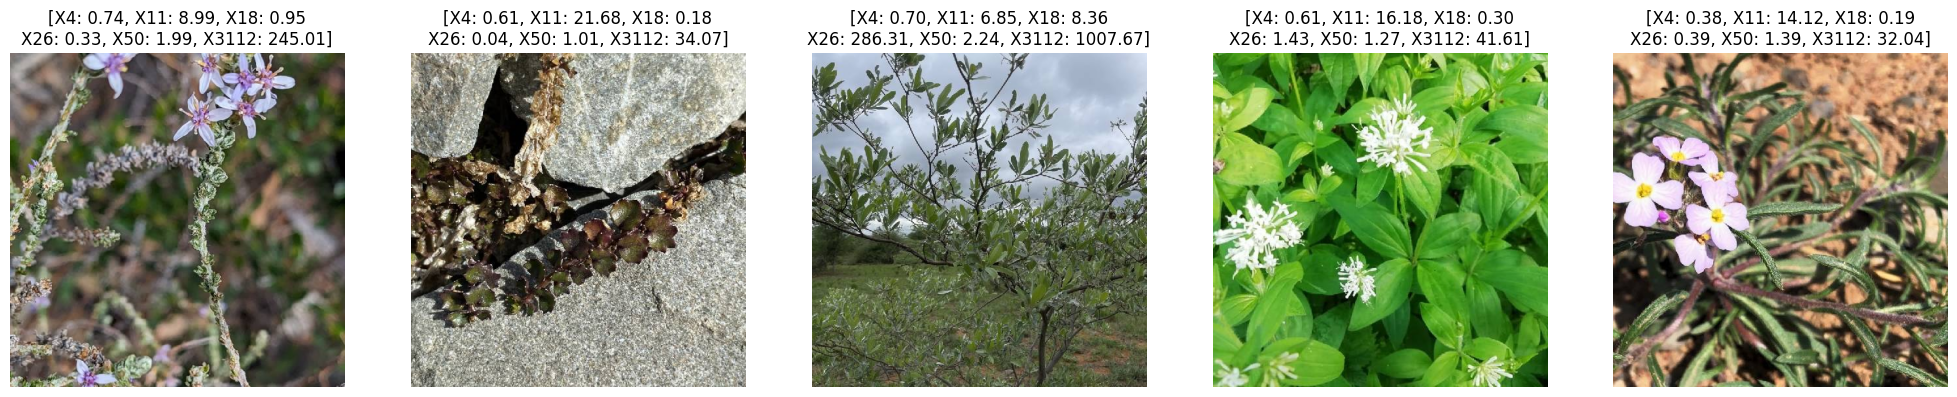

In [10]:
def test_image_viewer(df):
    # slice the df to only include the columns we want
    img_df = df[["image_path"] + config.class_names]
# sample 5 rows 
    img_df = img_df.sample(5)

    img, traits = list(img_df["image_path"].values), list(img_df[config.class_names].values)

    num_imgs, num_cols = 5, 5

    plt.figure(figsize=(5 * num_cols, num_imgs // num_cols * 5))
    for i, (img, traits) in enumerate(zip(img, traits)):
        plt.subplot(num_imgs // num_cols, num_cols, i + 1)
        img = cv2.imread(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
        formatted_tar = "\n".join(
        [
            ", ".join(
                f"{name.replace('_mean','')}: {val:.2f}"
                for name, val in zip(config.class_names[j : j + 3], traits[j : j + 3])
            )
            for j in range(0, len(config.class_names), 3)
        ]
    )
    
        plt.imshow(img)
        plt.title(f"[{formatted_tar}]")
        plt.axis("off")
        
    plt.show()

test_image_viewer(df)

## data split

In [11]:
from config import config
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=config.num_folds, shuffle=True, random_state=42)

# Create separate bin for each traits
for i, trait in enumerate(config.class_names):
    bin_edges = np.percentile(df[trait], np.linspace(0, 100, config.num_folds + 1))
    df[f"bin_{i}"] = np.digitize(df[trait], bin_edges)

df["final_bin"] = (
    df[[f"bin_{i}" for i in range(len(config.class_names))]]
    .astype(str)
    .agg("".join, axis=1)
)

# Perform the stratified split using final bin
df = df.reset_index(drop=True)
for fold, (train_idx, valid_idx) in enumerate(skf.split(df, df["final_bin"])):
    df.loc[valid_idx, "fold"] = fold

/home/applesauce/vu-ml-project/.venv/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X3112_sd,image_path,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,15.045054,../data/train_images/192027691.jpeg,2,2,1,2,4,1,221241,2.0
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,11.004477,../data/train_images/195542235.jpeg,3,3,2,2,2,3,332223,1.0


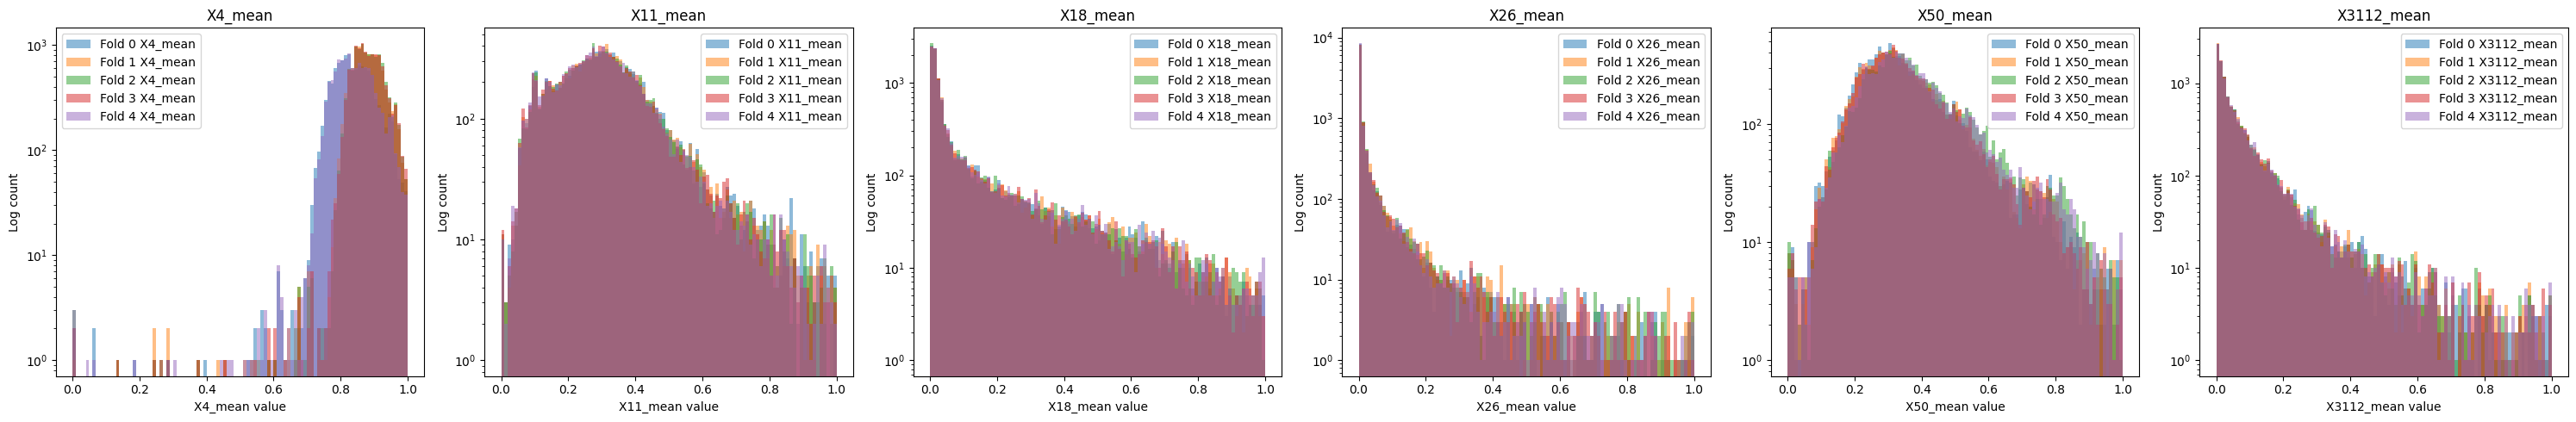

In [12]:
fig, ax = plt.subplots(1, 6, figsize=(30, 5))

display(df.head(2))

avg_hist = {i: [] for i in range(6)}

for j in range(5):
    for i in range(6):
        fold_n = df[df["fold"] == j]
        plt_df = fold_n[config.class_names[i]]
        
        plt_df = plt_df[plt_df.between(plt_df.quantile(0), plt_df.quantile(0.99))]
        
        avg_hist[i].append(plt_df)
        plt_df = (plt_df - plt_df.min()) / (plt_df.max() - plt_df.min())
        
        ax[i].hist(plt_df, bins=100, log=True, alpha=0.5, label=f"Fold {j} {config.class_names[i]}")
        ax[i].set_title(config.class_names[i])
        ax[i].set_xlabel(f"{config.class_names[i]} value")
        ax[i].set_ylabel("Log count")
        ax[i].legend()
    
    
fig.tight_layout()
plt.show()

Cool ok so we know that visually the traits are equally distributed in the different folds, so that confirms that, now it might make sense to like quantifably check this. We can I think just average the histograms then compare the distance (I think its called?) with that of the original distribution.

In [13]:
import pprint
print(list(avg_hist.values())[0][1].shape)
x4 = list(avg_hist.values())[0][1]
# print nan in x4
series_list = list(avg_hist.values())

series_list = list(map(lambda x: pd.DataFrame(x).sum(axis=0) / 5, series_list))

for i in range(6):
    print(series_list[i].isna().sum())

(10988,)
0
0
0
0
0
0


Distribution difference for X4_mean: 0.7761379612690126
Distribution difference for X11_mean: 2.82524732898307
Distribution difference for X18_mean: 0.5200729579615024
Distribution difference for X26_mean: 7.194992585373712
Distribution difference for X50_mean: 0.03845122658298907
Distribution difference for X3112_mean: 363.3889291321325


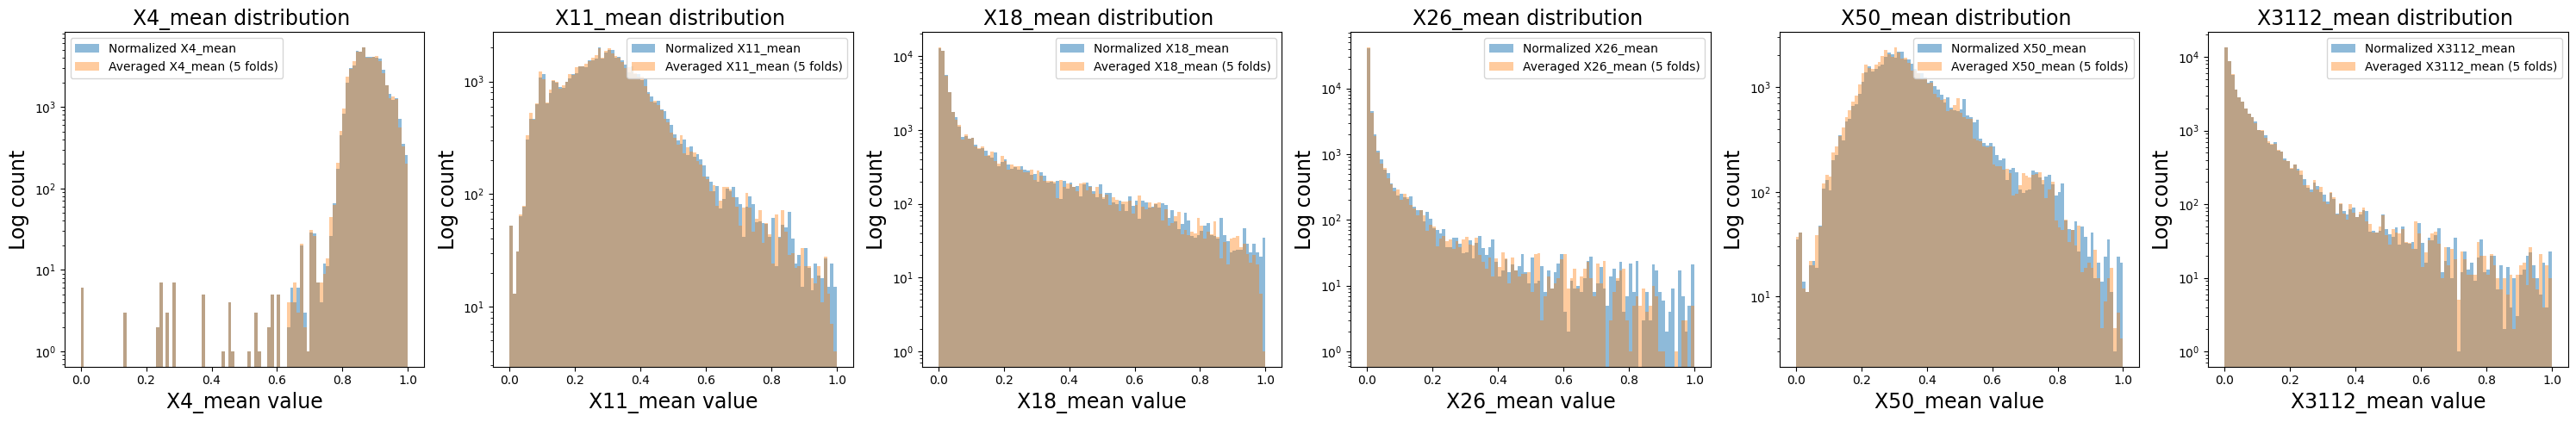

In [14]:
mean_traits = df.iloc[:, 164:170]

fig, ax = plt.subplots(1, 6, figsize=(30, 5))

for i, (x_mean_col, avrg_mean) in enumerate(zip(mean_traits.columns, series_list)):
    x_mean = mean_traits[x_mean_col]
    x_mean = x_mean[x_mean.between(x_mean.quantile(0), x_mean.quantile(0.99))]
    x_mean = (x_mean - x_mean.min()) / (x_mean.max() - x_mean.min())

    avrg_mean = avrg_mean[:54934]

    # TODO - maybe use something better than wasserstein distance to eval the distributions
    print(f"Distribution difference for {config.class_names[i]}: {wasserstein_distance(x_mean, avrg_mean)}")

    avrg_mean = (avrg_mean - avrg_mean.min()) / (avrg_mean.max() - avrg_mean.min())
    ax[i].hist(x_mean, bins=100, log=True, alpha=0.5, label=f"Normalized {config.class_names[i]}")
    ax[i].hist(avrg_mean, bins=100, log=True, alpha=0.4, label=f"Averaged {config.class_names[i]} (5 folds)")
    ax[i].set_title(f"{config.class_names[i]} distribution ", fontsize=17)
    ax[i].set_xlabel(f"{config.class_names[i]} value", fontsize=17)
    ax[i].set_ylabel("Log count", fontsize=17)
    ax[i].legend()

fig.tight_layout()
plt.show()

In [15]:
from sklearn.preprocessing import StandardScaler
from databuilder import build_dataset

# Sample from full data
sample_df = df.copy()
train_df = sample_df[sample_df.fold != config.fold]
valid_df = sample_df[sample_df.fold == config.fold]
print(f"# Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

# Normalize features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[FEATURE_COLS].values)
valid_features = scaler.transform(valid_df[FEATURE_COLS].values)

# Train | img + geo
train_paths = train_df.image_path.values
train_labels = train_df[config.class_names].values
train_aux_labels = train_df[config.aux_class_names].values
train_ds_ig = build_dataset(train_paths, train_features, train_labels, train_aux_labels,
                         batch_size=config.batch_size, cache_dir=f"{DATA_PATH}/cached_training",
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid | img + geo
valid_paths = valid_df.image_path.values
valid_labels = valid_df[config.class_names].values
valid_aux_labels = valid_df[config.aux_class_names].values
valid_ds = build_dataset(valid_paths, valid_features, valid_labels, valid_aux_labels,
                         batch_size=config.batch_size, cache_dir=f"{DATA_PATH}/cached_training",
                         repeat=False, shuffle=False, augment=False, cache=False)

# Train | img
train_ds_i = build_dataset(train_paths, None,train_labels, train_aux_labels,
                         batch_size=config.batch_size, cache_dir=f"{DATA_PATH}/cached_training",
                         repeat=True, shuffle=True, augment=True, cache=False)

# Valid | img
valid_ds_i = build_dataset(valid_paths, None, valid_labels, valid_aux_labels,
                         batch_size=config.batch_size, cache_dir=f"{DATA_PATH}/cached_training",
                         repeat=False, shuffle=False, augment=False, cache=False)

# Num Train: 44391 | Num Valid: 11098


2024-03-27 22:44:51.576826: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20551 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


In [16]:
display(train_df.head(2))

,id,WORLDCLIM_BIO1_annual_mean_temperature,WORLDCLIM_BIO12_annual_precipitation,WORLDCLIM_BIO13.BIO14_delta_precipitation_of_wettest_and_dryest_month,WORLDCLIM_BIO15_precipitation_seasonality,WORLDCLIM_BIO4_temperature_seasonality,WORLDCLIM_BIO7_temperature_annual_range,SOIL_bdod_0.5cm_mean_0.01_deg,SOIL_bdod_100.200cm_mean_0.01_deg,SOIL_bdod_15.30cm_mean_0.01_deg,...,X3112_sd,image_path,bin_0,bin_1,bin_2,bin_3,bin_4,bin_5,final_bin,fold
0,192027691,12.235703,374.466675,62.524445,72.256844,773.592041,33.277779,125,149,136,...,15.045054,../data/train_images/192027691.jpeg,2,2,1,2,4,1,221241,2.0
1,195542235,17.270555,90.239998,10.351111,38.220940,859.193298,40.009777,124,144,138,...,11.004477,../data/train_images/195542235.jpeg,3,3,2,2,2,3,332223,1.0


# Model design

## loss function

In [17]:
# loss function for model
from loss import R2Loss, R2Metric, adjusted_R2Loss

# testing r2
y_true = np.array([1, 2, 3, 4, 5])
y_pred = np.array([1, 1, 3, 4, 5])

r2 = R2Metric()
r2.update_state(y_true, y_pred)
print(r2.result())

tf.Tensor(0.8999999, shape=(), dtype=float32)


## image model

### backbone comparison

In [18]:
from loss import *
from config import config
from model import Model 

# comparing differen backbones
nn1 = Model(config, "efficientnetv2_b2_imagenet")
nn2 = Model(config, "resnet50_imagenet")
nn3 = Model(config, "efficientnetv2_s_imagenet")

Compiling model
Compiling model
Compiling model


In [19]:
from loss import *
from config import config
from model import Model 

nn1 = Model(config, "efficientnetv2_b2_imagenet")
nn1.summary()

Compiling model


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficient_net_v2_b… │ (None, 7, 7,      │  8,769,374 │ images[0][0]      │
│ (EfficientNetV2Bac… │ 1408)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1408)      │          0 │ efficient_net_v2… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │  1,442,816 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    524,800 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ aux_head (Dense)    │ (None, 6)         │      3,078 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ head (Dense)        │ (None, 6)         │      3,078 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,743,146 (40.98 MB)

 Trainable params: 10,660,858 (40.67 MB)

 Non-trainable params: 82,288 (321.44 KB)

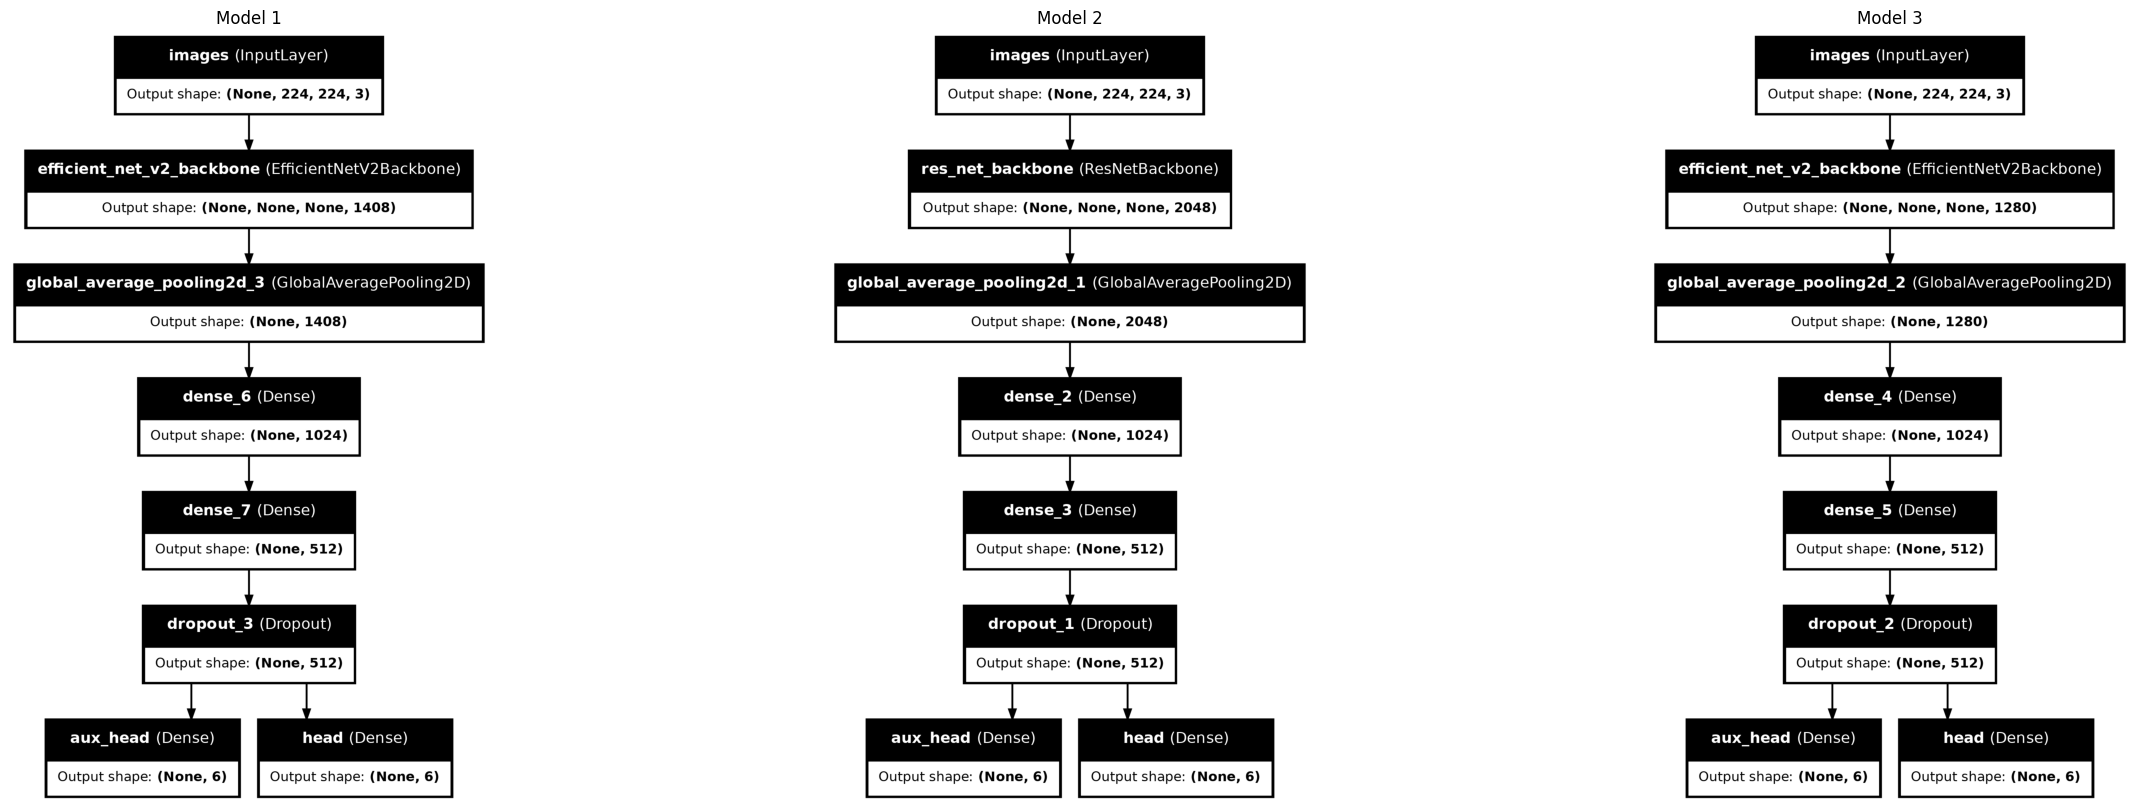

In [20]:
# 1 x 3 keras model plot 
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

# TODO - causes errors
plot_model(nn1, to_file='model_nn1.png', show_shapes=True, show_layer_names=True)
plot_model(nn2, to_file='model_nn2.png', show_shapes=True, show_layer_names=True)
plot_model(nn3, to_file='model_nn3.png', show_shapes=True, show_layer_names=True)

# Load and display the images
img1 = plt.imread('model_nn1.png')
img2 = plt.imread('model_nn2.png')
img3 = plt.imread('model_nn3.png')

# Delete the images after loading them
os.remove('model_nn1.png')
os.remove('model_nn2.png')
os.remove('model_nn3.png')

ax[0].imshow(img1)
ax[0].axis('off')
ax[0].set_title('Model 1')

ax[1].imshow(img2)
ax[1].axis('off')
ax[1].set_title('Model 2')

ax[2].imshow(img3)
ax[2].axis('off')
ax[2].set_title('Model 3')

plt.show()

### training

In [21]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': 
            print(epoch - lr_ramp_ep - lr_sus_ep)
            print("here")
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    lrfn(5)

    # if plot:  # Plot lr curve if plot is True
    #     plt.figure(figsize=(10, 5))
    #     plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
    #     plt.xlabel('epoch'); plt.ylabel('lr')
    #     plt.title('LR Scheduler')
    #     plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False) 

lr_cb = get_lr_callback(config.batch_size, mode=config.lr_mode, plot=True)

2
here


In [22]:
nn1.name = "nn1"
print(nn1.name)
nn2.name = "nn2"
nn3.name = "nn3"

nn1


In [23]:
import pickle

histories = []

# make dir ../data/weights
if not os.path.exists("../data/weights"):
    os.makedirs("../data/weights")
    
# make history dir 
if not os.path.exists("../data/history"):
    os.makedirs("../data/history")

for network in [nn1, nn2, nn3]:
    print(f"started training {network}")
    
    if os.path.exists(f"../data/weights/{network.name}.keras"):
        print(f"weights for {network.name} already exist, skipping training")
        continue
    
    ckpt_cb = keras.callbacks.ModelCheckpoint(
        f"../data/weights/{network.name}.keras",
        monitor="val_head_r2",
        save_best_only=True,
        save_weights_only=False,
        mode="max",
    )
    
    history = network.fit(
        train_ds_i,
        epochs=config.epochs,
        callbacks=[lr_cb, ckpt_cb],
        steps_per_epoch=len(train_df) // config.batch_size,
        validation_data=valid_ds_i,
        verbose=config.verbose,
    )
    
    
    histories.append((history.history, ckpt_cb))
    # pickle dump history.history 
    with open(f"../data/history/{network.name}.pkl", "wb") as f:
        pickle.dump(history.history, f)

started training <Functional name=nn1, built=True>
weights for nn1 already exist, skipping training
started training <Functional name=nn2, built=True>
weights for nn2 already exist, skipping training
started training <Functional name=nn3, built=True>
Epoch 1/12


I0000 00:00:1711579593.654200  328449 service.cc:145] XLA service 0x7fc004015130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1711579593.654358  328449 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-03-27 22:46:36.838991: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-27 22:46:49.615889: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-03-27 22:47:38.273961: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.0 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I00

924/924 ━━━━━━━━━━━━━━━━━━━━ 818s 607ms/step - head_r2: -49.1997 - loss: 161.8503 - val_head_r2: nan - val_loss: nan - learning_rate: 5.0000e-05
Epoch 2/12
924/924 ━━━━━━━━━━━━━━━━━━━━ 543s 588ms/step - head_r2: -25.1038 - loss: 86.9871 - val_head_r2: nan - val_loss: nan - learning_rate: 1.6133e-04
Epoch 3/12
924/924 ━━━━━━━━━━━━━━━━━━━━ 544s 590ms/step - head_r2: -0.0956 - loss: 1.8809 - val_head_r2: nan - val_loss: nan - learning_rate: 2.7267e-04
0
here
Epoch 4/12
924/924 ━━━━━━━━━━━━━━━━━━━━ 558s 604ms/step - head_r2: -0.0429 - loss: 1.5674 - val_head_r2: nan - val_loss: nan - learning_rate: 3.8400e-04
1
here
Epoch 5/12
924/924 ━━━━━━━━━━━━━━━━━━━━ 550s 596ms/step - head_r2: -0.0424 - loss: 1.5030 - val_head_r2: nan - val_loss: nan - learning_rate: 3.8400e-04
2
here
Epoch 6/12
924/924 ━━━━━━━━━━━━━━━━━━━━ 532s 576ms/step - head_r2: -0.0385 - loss: 1.4715 - val_head_r2: nan - val_loss: nan - learning_rate: 2.8800e-04
3
here
Epoch 7/12
924/924 ━━━━━━━━━━━━━━━━━━━━ 544s 589ms/step - he

2024-03-28 00:38:40.390974: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node random_apply_26_1_map_while_body_3609}}{{node random_apply_26_1/map/while/stateful_uniform/RngReadAndSkip}}]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-03-28 00:38:40.391061: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: CANCELLED: RecvAsync is cancelled.
	 [[{{function_node random_apply_26_1_map_while_body_3609}}{{node random_apply_26_1/map/while/stateful_uniform/RngReadAndSkip}}]]
	 [[random_apply_25_1/map/while/LoopCond/_274/_320]] [type.googleapis.com/tensorflow.DerivedStatus='']
2024-03-28 00:38:40.391087: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7000162101137768525
2024-03-28 00:38:40.391098: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key

### visualizations

Ok so we wanna plot the different r2 loss for the diff models with their respective backbones

In [39]:
for h in histories: 
    print(h.keys())

dict_keys(['head_r2', 'loss', 'val_head_r2', 'val_loss', 'learning_rate'])
dict_keys(['head_r2', 'loss', 'val_head_r2', 'val_loss', 'learning_rate'])
dict_keys(['head_r2', 'loss', 'val_head_r2', 'val_loss', 'learning_rate'])


nn3.pkl
nn2.pkl
nn1.pkl
{'head_r2': [-24.228538513183594, -0.746569812297821, -0.04361772537231445, -0.04052412509918213, -0.03811581805348396, -0.03417833521962166, -0.03534897044301033, -0.029484311118721962, -0.03030794858932495, -0.029914477840065956, -0.030529042705893517, -0.02919658087193966], 'loss': [71.129638671875, 3.910341501235962, 1.6837962865829468, 1.5755140781402588, 1.5055392980575562, 1.474176287651062, 1.4705698490142822, 1.4475857019424438, 1.4421504735946655, 1.440633773803711, 1.4376065731048584, 1.4299893379211426], 'val_head_r2': [-1.0613619089126587, -0.07768233865499496, -0.11133414506912231, -0.07094430923461914, -0.0671708807349205, -0.07277286052703857, -0.055317580699920654, -0.08293453603982925, -0.05215322971343994, -0.0840350016951561, -0.11889183521270752, -0.04116592928767204], 'val_loss': [4.297310829162598, 1.8506944179534912, 1.7503644227981567, 1.541786551475525, 1.5361732244491577, 1.5251107215881348, 1.5655492544174194, 1.4691938161849976, 1.47

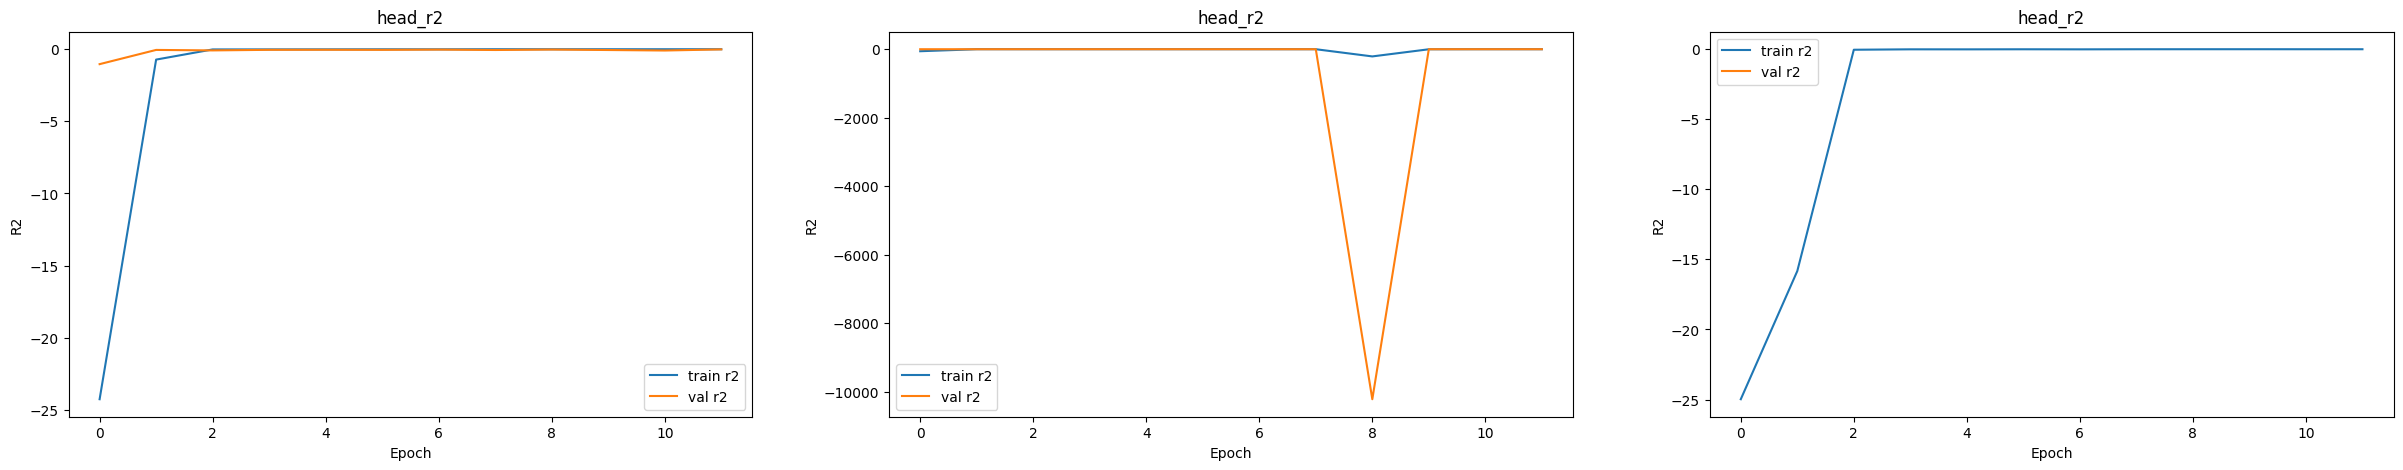

In [41]:
# load history.history as ../data/functional_1.pkl
histories = []
for i in os.listdir("../data/history"):
    if not i.endswith(".pkl"):
        continue
    
    with open(f"../data/history/{i}", "rb") as f:
        print(i)
        histories.append(pickle.load(f))

fig, ax = plt.subplots(1, 3, figsize=(30, 5))

histories = list(reversed(histories))

for idx, i in enumerate(histories):
    print(i)
    best_R2 = max(i['head_r2'])
    best_Epoch = np.argmax(i['head_r2']) + 1
    print("#" * 10 + " Result " + "#" * 10)
    print(f"Best R2: {best_R2:.5f}")
    print(f"Best Epoch: {best_Epoch}")
    print("#" * 28)
    
    print(i.keys())
    
    ax[idx].plot(i['head_r2'], label='train r2')
    ax[idx].plot(i['val_head_r2'], label='val r2')
    ax[idx].set_xlabel('Epoch')
    ax[idx].set_ylabel('R2')
    ax[idx].set_title(f"{list(histories[idx].keys())[0]}")
    ax[idx].legend()

In [25]:
DATA_PATH = "../data"

# we wanna load the models
# nn1 = keras.models.load_model(f"../data/weights/old1/functional_3.keras")

# sample image
img_path = f'{DATA_PATH}/train_images/26375.jpeg'

In [10]:
nn3 = keras.models.load_model("../data/weights/nn3.keras")
nn3.summary()

ValueError: File not found: filepath=../data/weights/nn3.keras. Please ensure the file is an accessible `.keras` zip file.

In [47]:
nn1.layers

[<InputLayer name=images, built=True>,
 <EfficientNetV2Backbone name=efficient_net_v2_backbone, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=aux_head, built=True>,
 <Dense name=head, built=True>]

We can check the intermediate activations here

In [7]:
from keras.models import Model
import numpy as np
import cv2

# Load the model
nn1 = keras.models.load_model("../data/weights/nn1.keras")

# Load and preprocess the image
img_path = "../data/train_images/26375.jpeg"
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))  
img = np.expand_dims(img, axis=0) 
img = img / 255.0 

# Create a new model that outputs the output of the dense_1 layer
dense_output_model = Model(inputs=nn1.input, outputs=nn1.get_layer('efficient_net_v2_backbone').output)

# Get the output of the dense_1 layer for your image
efficient_net_out = dense_output_model.predict(img)

print(efficient_net_out)

efficient_net_out = pd.DataFrame(efficient_net_out)
print(efficient_net_out)

# plot the efficient_net_out
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(efficient_net_out.T)

KeyError: 'Exception encountered when calling Functional.call().\n\n\x1b[1m139873615057376\x1b[0m\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(1, 224, 224, 3), dtype=float32)\n  • training=False\n  • mask=None'

### evaluation + tuning

In [ ]:
# evaluting model and tuning hyperparameters

# training, validation acc 

# training, validation loss


## ensemble model

In [ ]:
# outline for the ensemble model

### training

### evaluation + tuning

In [ ]:
# evaluating ensemble model and tuning hyperparameters

## ensemble vs image model 

### performance evaluation

### conclusion 

( you can use any notes here in the paper )